In [25]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [123]:
def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''

    z = lowess(np.array(y),np.array(x),frac=0.05)
    y2 = z[:,1]
    plt.plot(x,y2, **kwargs)

def control_ylim(x, y, **kwargs):
    maxy = max(y)
    miny = min(y)
    print(maxy, miny)
    plt.ylim([miny,maxy])
    
def classify(n, width):
    wsize = 500
    center = width-10e3
    hcenter = center/2
    if abs(n)<=hcenter:
        return 0
    else:
        new_n = abs(n)-hcenter
        return_n = (round(new_n/wsize)+1)*wsize
        if n<=0:
            return -1*return_n
        else:
            return return_n

Read data

In [128]:
d = pd.read_csv("../merged_results/merged.parsimony.tab.gz", sep="\t", header=None)
d.columns = ["branch", "gcstar", "derived_subs", "bps", "rel_pos", "cpgi1", "cpgi2", "spot_id0", "spot_id2", "nature", "lift_bp", "dist_bp", "heat"]
d = d[(d.cpgi2>=0) & (d.cpgi1>=0)].reset_index()

Split the "nature" col into "spot" and "sp", and correctly annotated spot_id

In [129]:
d["spot"] = [n.split(".")[1] for n in d.nature]
d["sp"] = [n.split(".")[0] for n in d.nature]
d["spot_id"] = ["{}:{}".format(str(r.spot_id0).split("_")[-1], str(r.spot_id2).split(":")[-1]) for i,r in d.iterrows()]

Annotate start and end of hotspot

In [130]:
d["start"] = [int(sp.split(":")[1].split("-")[0]) for sp in d.spot_id]
d["end"] = [int(sp.split(":")[1].split("-")[1]) for sp in d.spot_id]
d["width"] = d.end - d.start

Fixed the relative positions, given the hotspots have different widths

In [131]:
d["trel_pos"] = [classify(r.rel_pos, r.width) for i,r in d.iterrows()]

Classify into close or far from CpG islands

In [132]:
th = 1e3
d["cpgi1_bool"] = ["close" if distance<=th else "far" if distance>=10e3 else "intermediate" for distance in d.cpgi1]
d["cpgi2_bool"] = ["close" if distance<=th else "far" if distance>=10e3 else "intermediate" for distance in d.cpgi2]

Exclude the Z chromosome

In [133]:
d = d[~d.spot_id.str.contains("Z")]

Classify as shared or not

In [134]:
th = 1500
d["shared"] = ["shared" if lift>th else "not-shared" for lift in d.lift_bp]

Compute mean GC* across windows centered from spots

In [135]:
d["hue_kind"] = d.spot + "." + d.cpgi2_bool
subd = d[(d.bps>100) &
         (d.heat>5) &
         (d.cpgi2_bool!="intermediate")]
xvar = "rel_pos"
m = subd.groupby(["branch", xvar, "hue_kind", "sp"])["gcstar"].mean().reset_index() #[d.bps>50]

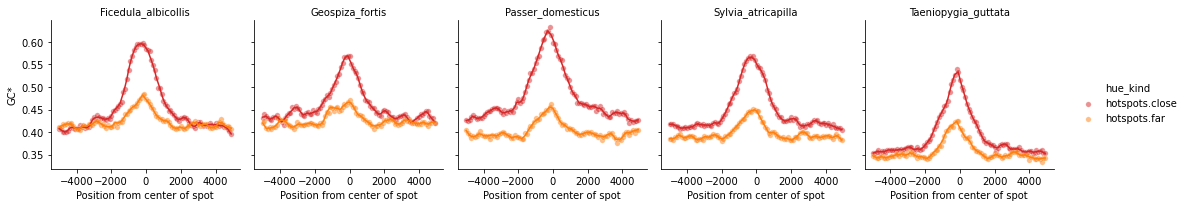

In [136]:
palette = {"coldspots.close":"C0", "coldspots.far":"C2",
           "hotspots.close":"C3", "hotspots.far":"C1"}

g = sns.FacetGrid(data=m[m[xvar].between(-5000,5000)], col="branch", 
                  hue="hue_kind", palette=palette, 
                  sharey=True)

g.map(sns.scatterplot, "rel_pos", "gcstar", s=30, alpha=0.5)
g.map(plot_lowess, "rel_pos", "gcstar")
g.add_legend()

for gr,ax in g.axes_dict.items():
    branch = gr
    ssubd = m[(m.sp==sp) & (m.branch==branch)]
#    ax.set_ylim([ssubd.gcstar.min()*0.9, ssubd.gcstar.max()*1.1])

g.tight_layout()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels("Position from center of spot", "GC*")
g.savefig("pdfs/zebra_finch_hotspots_distCpGi.pdf")

Shared hotspots?

In [18]:
d["hue_kind"] = d.shared + "." + d.cpgi2_bool
subd = d[(d.bps>100) 
         & (d.cpgi2_bool!="intermediate")
         & (d.heat>10) 
         & (d.nature.str.contains("hotspot")) 
         & (~d.lift_bp.isnull())]
m = subd.groupby(["branch", "rel_pos", "hue_kind", "sp"])["gcstar"].median().reset_index() #[d.bps>50]

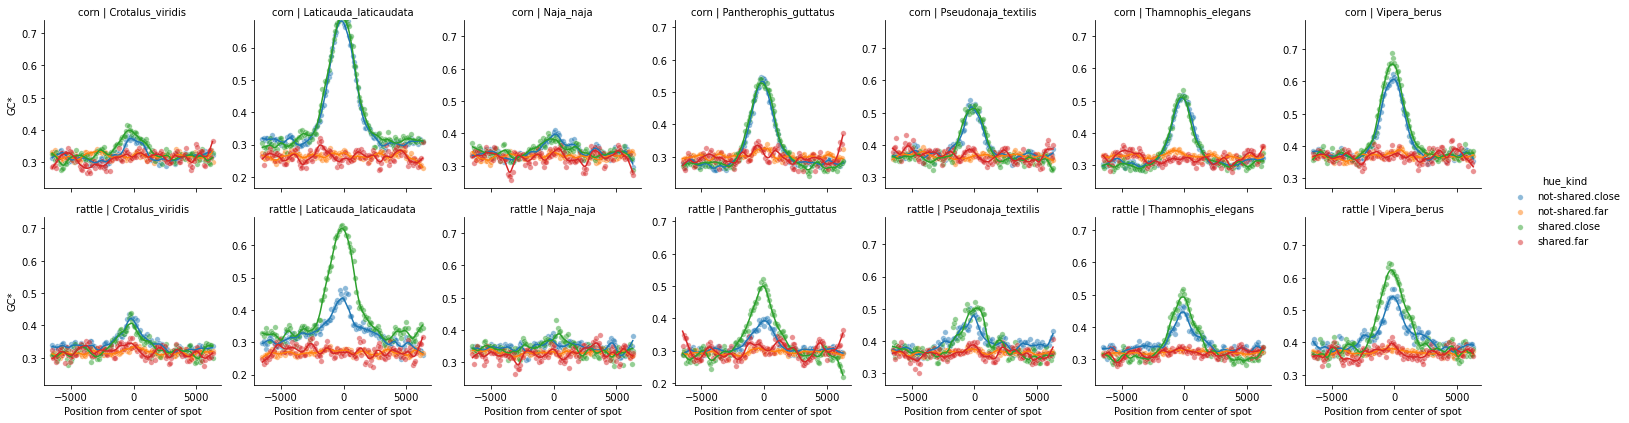

In [19]:
g = sns.FacetGrid(data=m, row="sp", col="branch", 
                  hue="hue_kind", 
                  sharey=False)

g.map(sns.scatterplot, "rel_pos", "gcstar", s=30, alpha=0.5)
g.map(plot_lowess, "rel_pos", "gcstar")
g.add_legend()

for gr,ax in g.axes_dict.items():
    sp, branch = gr
    ssubd = m[(m.sp==sp) & (m.branch==branch)]
    ystab = ssubd[ssubd.hue_kind=="not-shared.far"]["gcstar"].mean()
    ax.set_ylim([ystab-0.1, ystab+0.42])

g.tight_layout()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels("Position from center of spot", "GC*")

#g.savefig("pdfs/corn_rattle_hotspots_sharing_lineagespecific_parsimony_heat10x.jpg",dpi=400)